In [1]:
import os
import sys
from pathlib import Path

import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from skimage import exposure, io
from skimage.util import img_as_ubyte
from tqdm.notebook import tqdm, trange

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

# Load IMC data

In [4]:
from functools import partial

import matplotlib.patches as mpatches
import skimage.io
from skimage.filters import median
from skimage.morphology import disk
from skimage.segmentation import mark_boundaries
from skimage.transform import rotate

d
def contrast_streching(img):
    p2, p98 = np.percentile(img, (0.1, 99.9))
    return exposure.rescale_intensity(img, in_range=(p2, p98))


def read_img_whole(path: str) -> np.ndarray:
    """
    Read image from path
    """
    img = io.imread(path, as_gray=True)
    img = contrast_streching(img)
    img = img_as_ubyte(img)
    return img


def read_img(path: str, region, rotation=-90) -> np.ndarray:
    """
    Read image from path
    """
    img = io.imread(path, as_gray=True)
    img_rescale = rotate(img, rotation)

    y, h_region, x, w_region = region
    img_rescale = img_rescale[y : y + h_region, x : x + w_region]
    img_rescale = contrast_streching(img_rescale)
    img_rescale = median(img_rescale, disk(1))
    img_rescale = img_as_ubyte(img_rescale)
    return img_rescale


def get_info(img_folder):
    """Function returns the info from folder containing multi-cycle staigning on cell

    Args:
        img_folder (str) : imgage folder path to get information
        name_dict (dict) : three level dictionnary mapping cycle -> channel -> marker name

    Returns:
        pandas dataframe with information
    """
    images_path = []
    markers = []

    # Loop through image folder
    for (dirpath, dirnames, filenames) in os.walk(img_folder):
        for name in sorted(filenames):
            if "ome.tiff" not in name:
                continue

            try:
                marker = name.split("_")[2].split(".")[0]
                if marker == "contaminant":
                    continue
                elif marker == "DNA":
                    if "191Ir" in name:
                        marker += "1"
                    else:
                        marker += "2"
            except:
                continue

            path = os.path.join(dirpath, name)
            markers.append(marker)
            images_path.append(path)

    info = {
        "Marker": markers,
        "Path": images_path,
    }
    df = pd.DataFrame(info)
    return df


def joblib_loop(task, pics):
    return Parallel(n_jobs=20)(delayed(task)(i) for i in pics)

In [58]:
core = "F4"
df = get_info(data_dir / "IMC" / core)
match_info_dir = p_dir / "data" / "match"

In [61]:
paths = df.Path.tolist()
markers = df.Marker.tolist()
imgs = joblib_loop(read_img_whole, paths)

In [62]:
from sklearn.neighbors import NearestNeighbors


def get_NN(data, n):
    fit = NearestNeighbors(n_neighbors=n).fit(data)
    distances, indices = fit.kneighbors(data)

    return distances, indices


def filter_img_knn(img, n=25, th=3.5):
    # Get avg distances per positive expressed pixels
    x, y = np.where(img > 0)
    values = img[x, y]

    data = np.column_stack((x, y))
    distances, indices = get_NN(data, n)
    # avg_dist = np.average(distances, axis=1, weights=values[indices])
    avg_dist = np.average(distances, axis=1)

    filter_ind = avg_dist > th
    unique, counts = np.unique(filter_ind, return_counts=True)
    print(unique, counts)
    x_fil = x[filter_ind]
    y_fil = y[filter_ind]

    img_fil = img.copy()
    img_fil[x_fil, y_fil] = 0

    return img_fil

SMA
[False  True] [661447  82238]


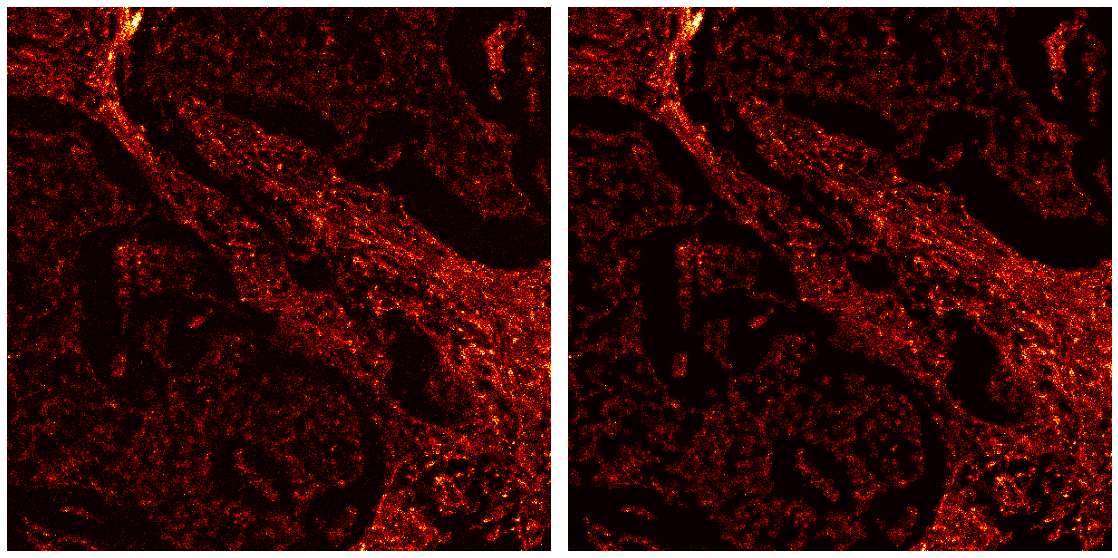

Vimentin
[False  True] [ 88169 177815]


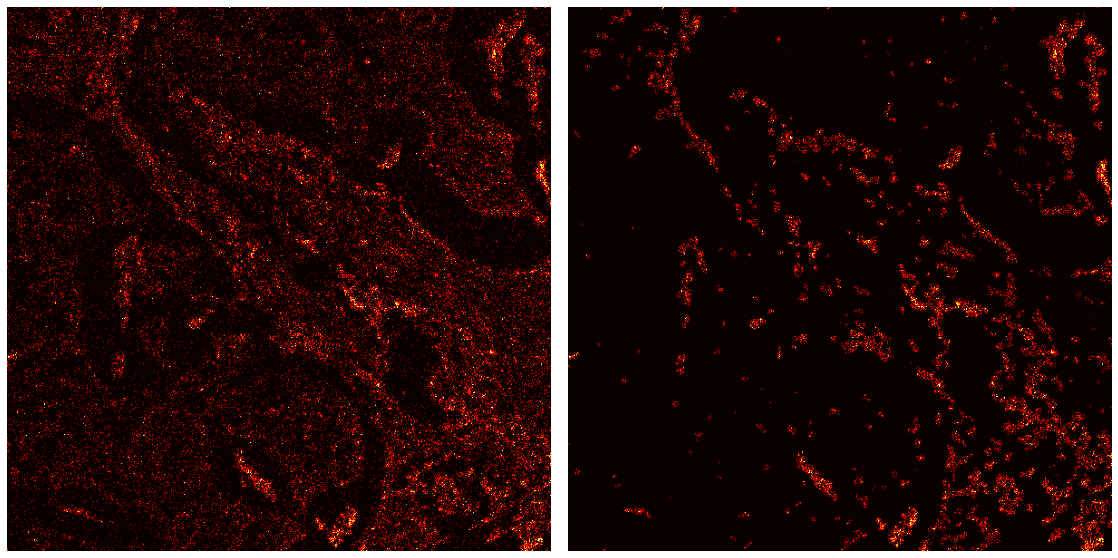

PanKeratin
[False  True] [192929 146806]


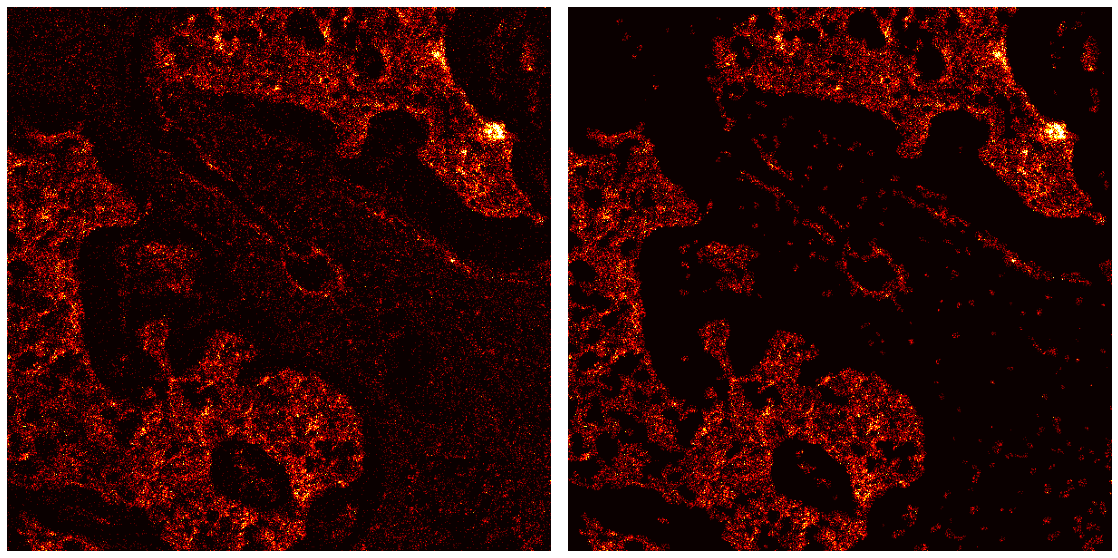

CD11b
[False  True] [   242 131605]


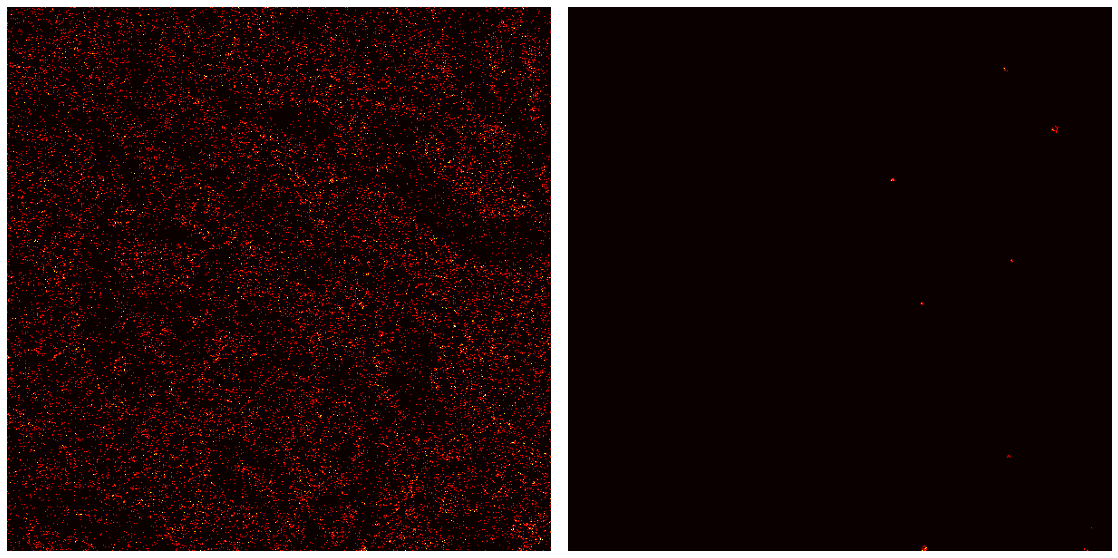

CD31
[False  True] [ 68322 158035]


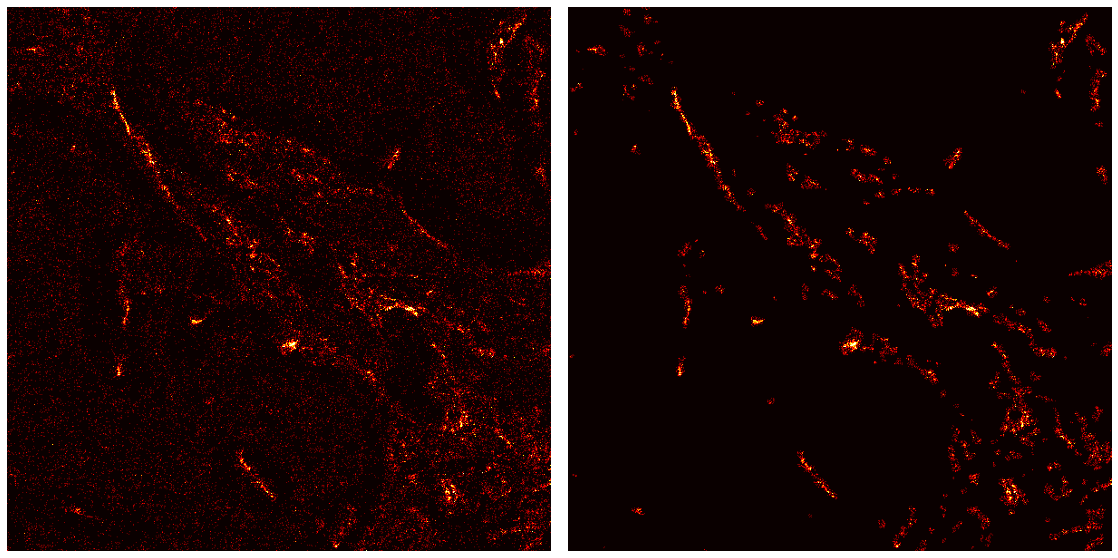

CD44
[False  True] [  1752 151559]


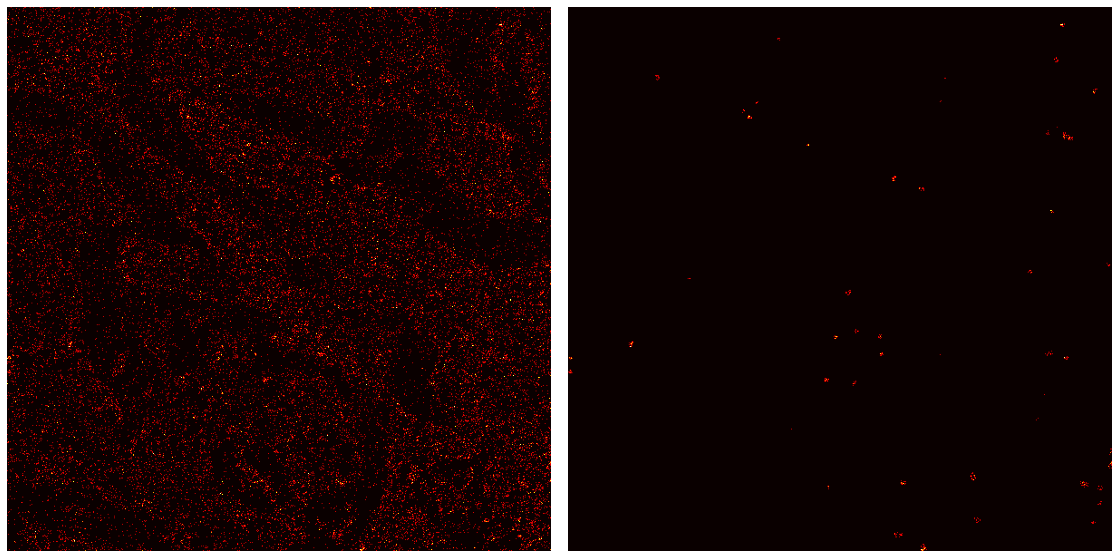

CD11c
[False  True] [128530 175745]


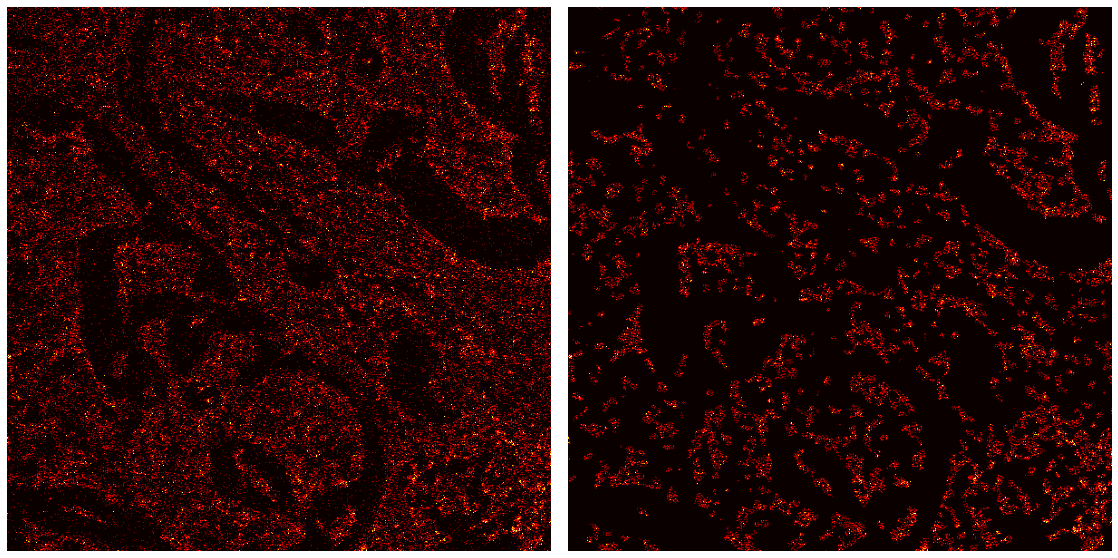

FoxP3
[False  True] [   178 116367]


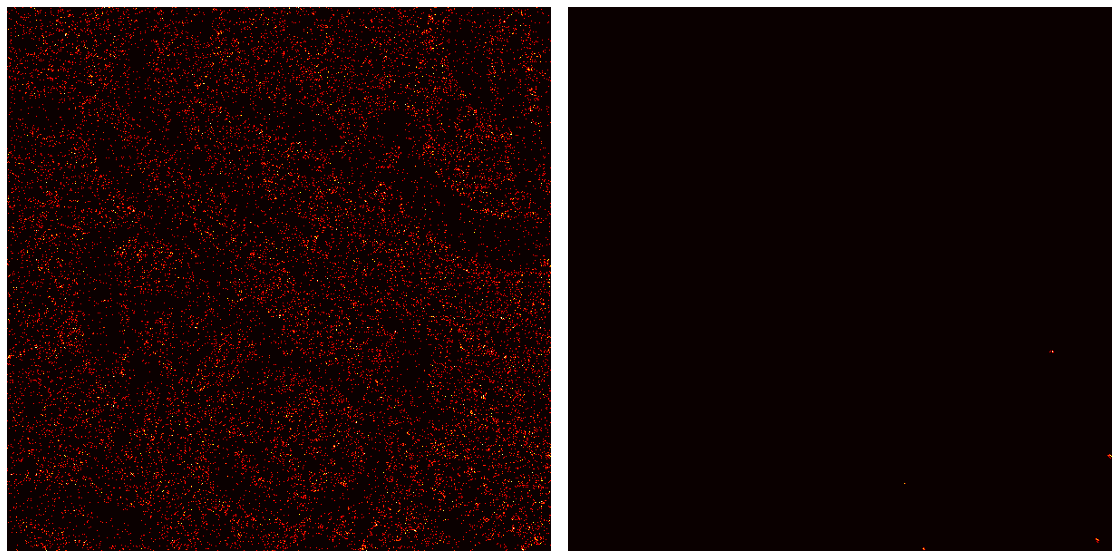

CD4
[False  True] [ 58986 115509]


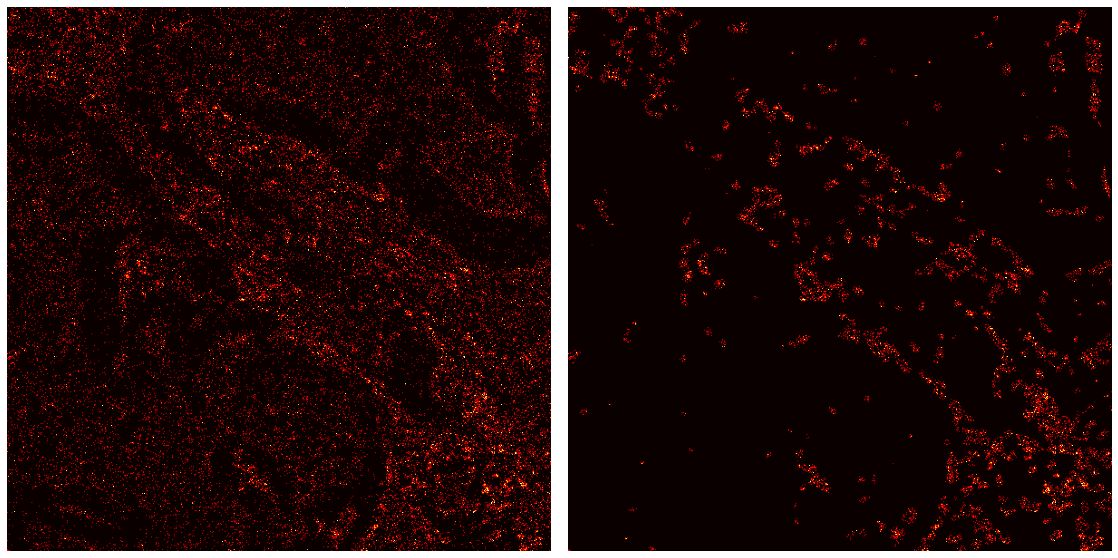

ECadherin
[False  True] [213006 129017]


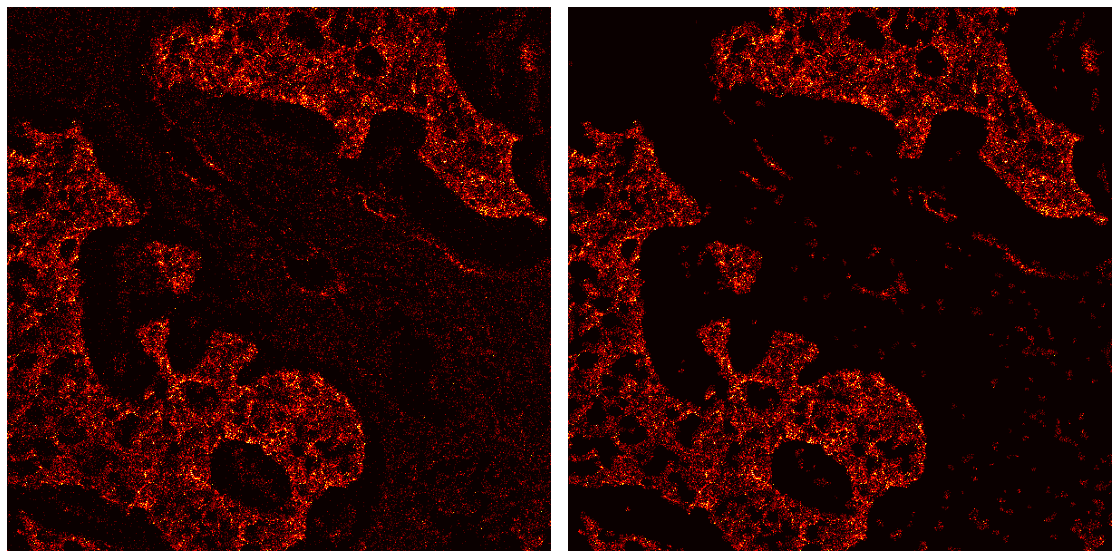

CD68
[False  True] [116053 144961]


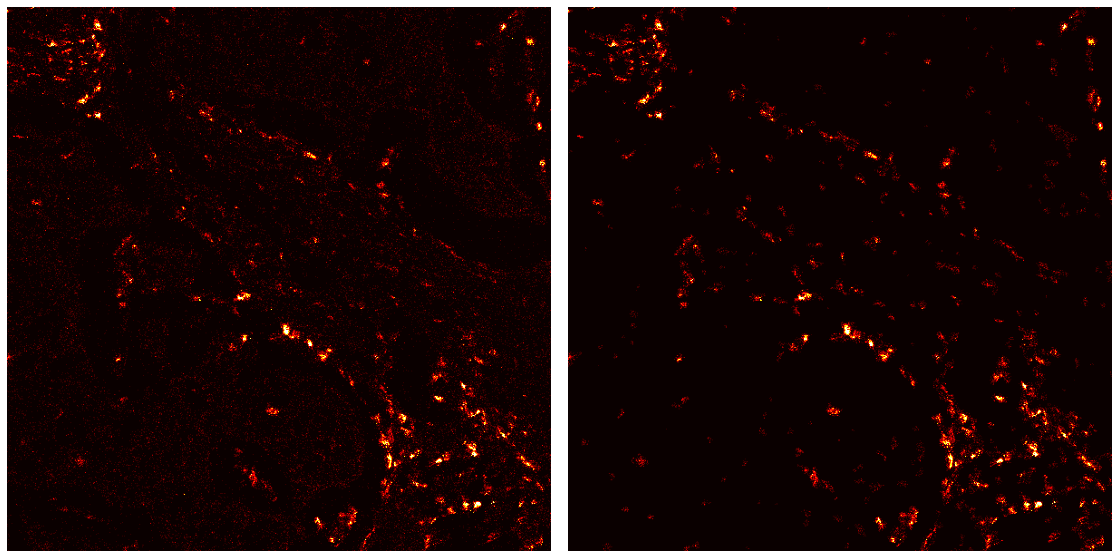

CD20
[False  True] [ 2723 45801]


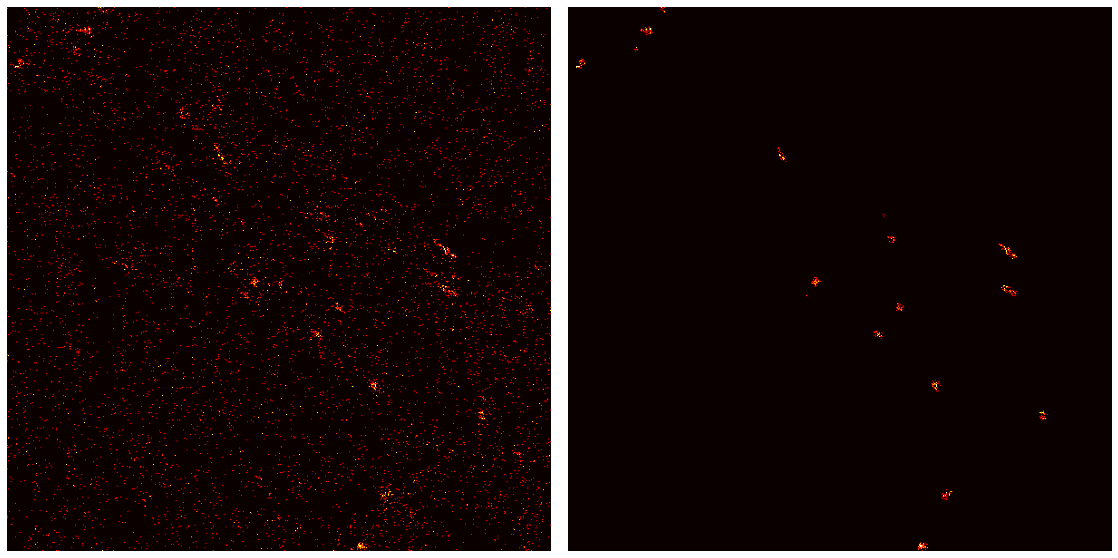

CD8
[False  True] [ 1397 88869]


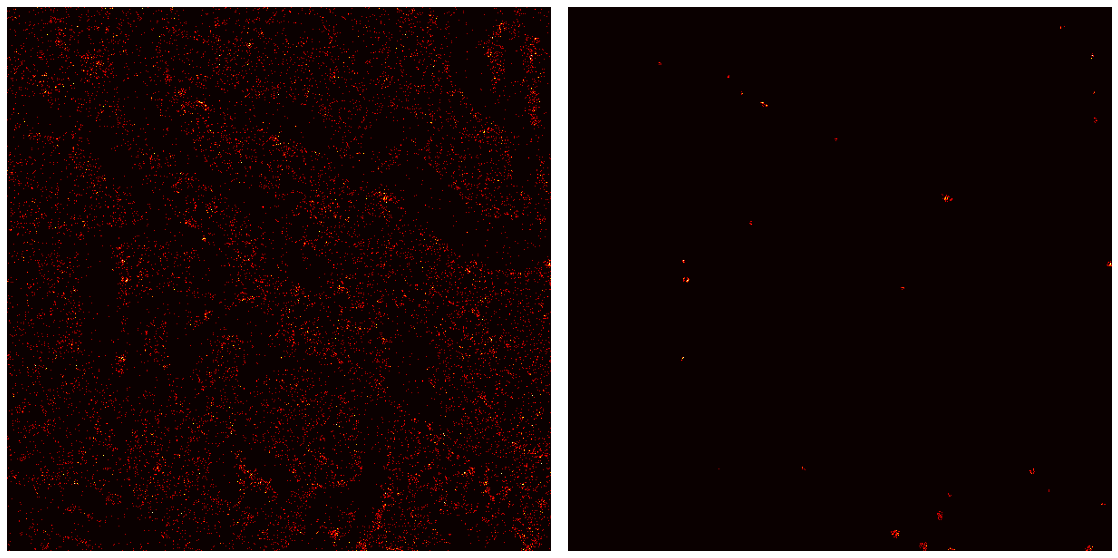

CD45RA
[False  True] [334397 107646]


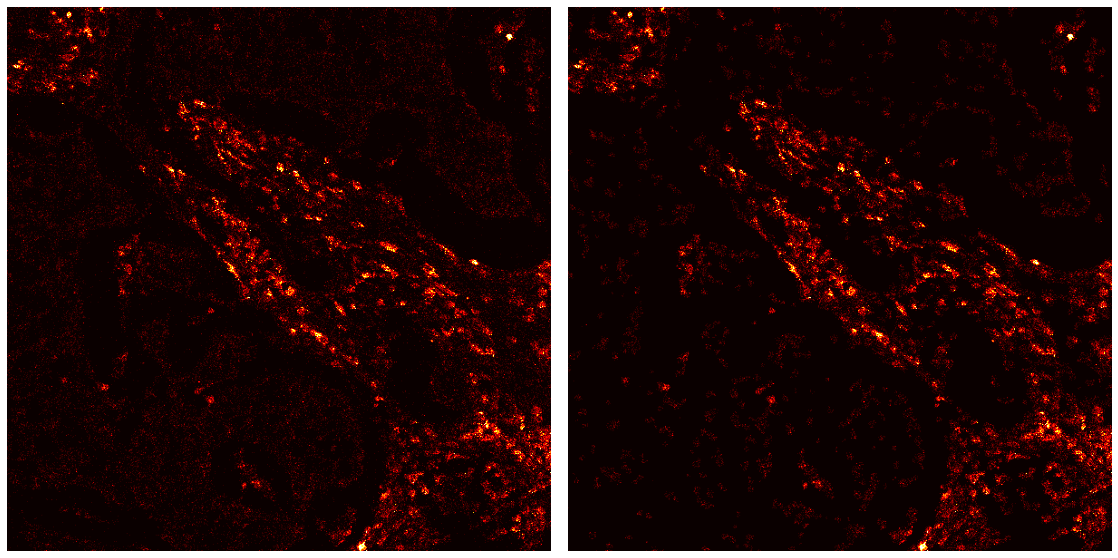

GranzymeB
[False  True] [ 7246 84214]


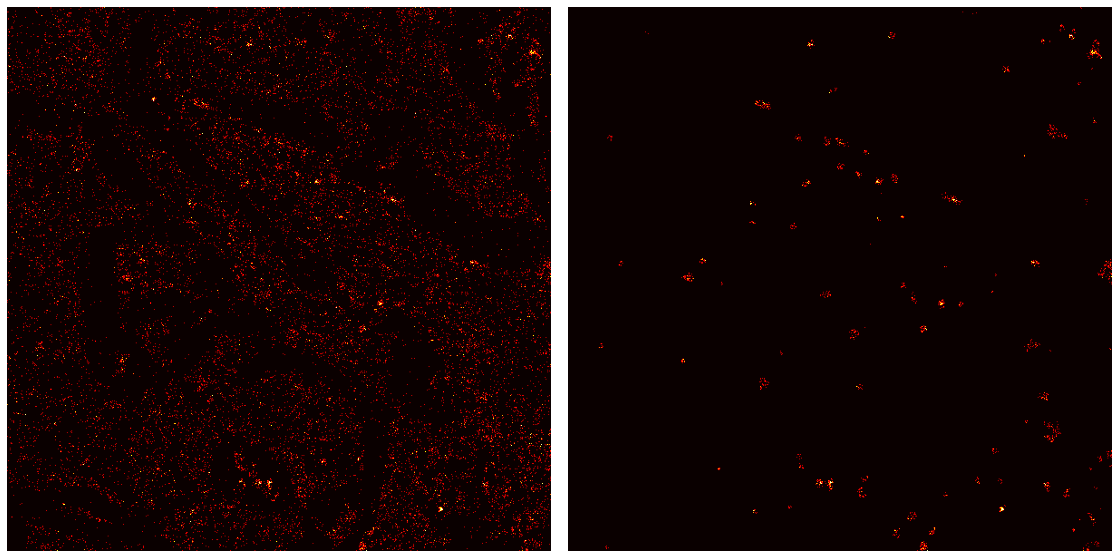

Ki67
[False  True] [ 4088 68953]


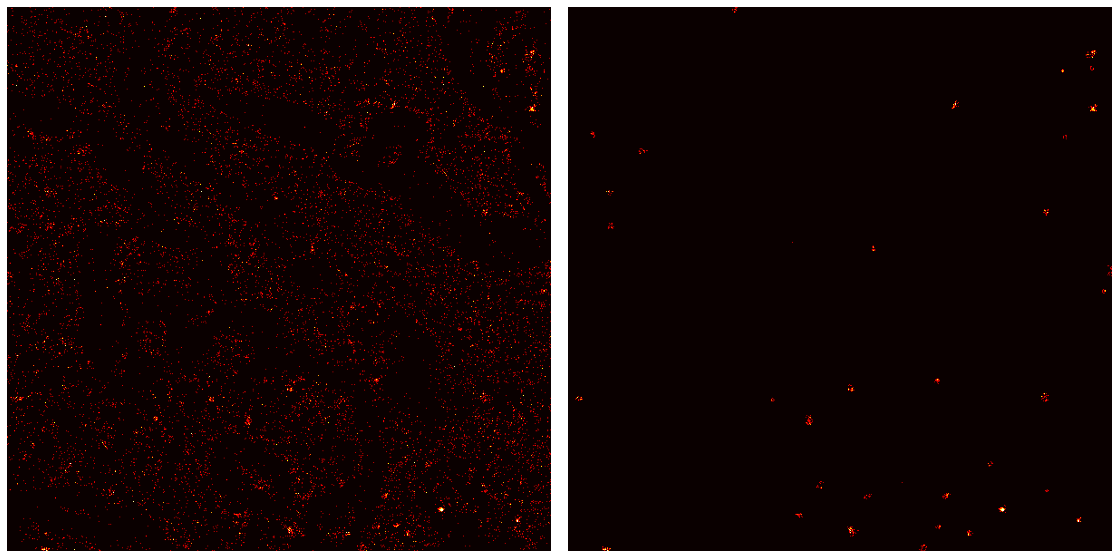

COL1
[False  True] [1261899   43281]


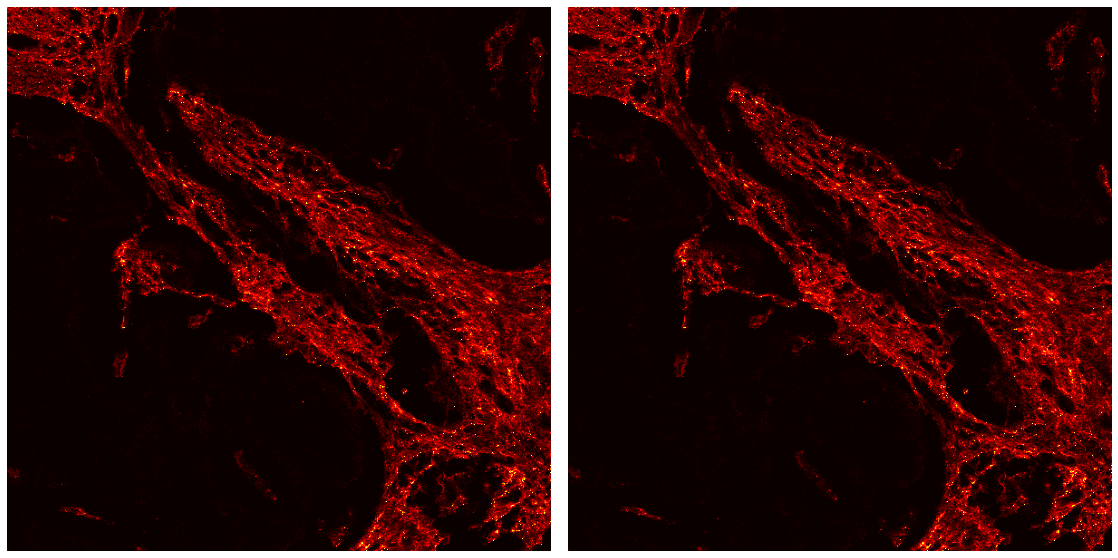

CD3
[False  True] [121174  73649]


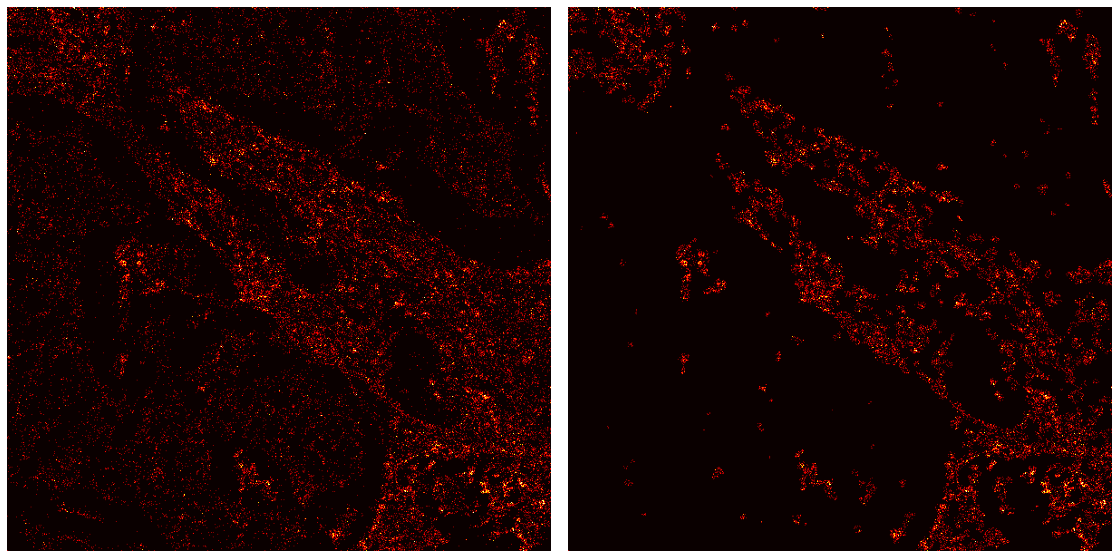

HistoneH3
[False  True] [1427965   33348]


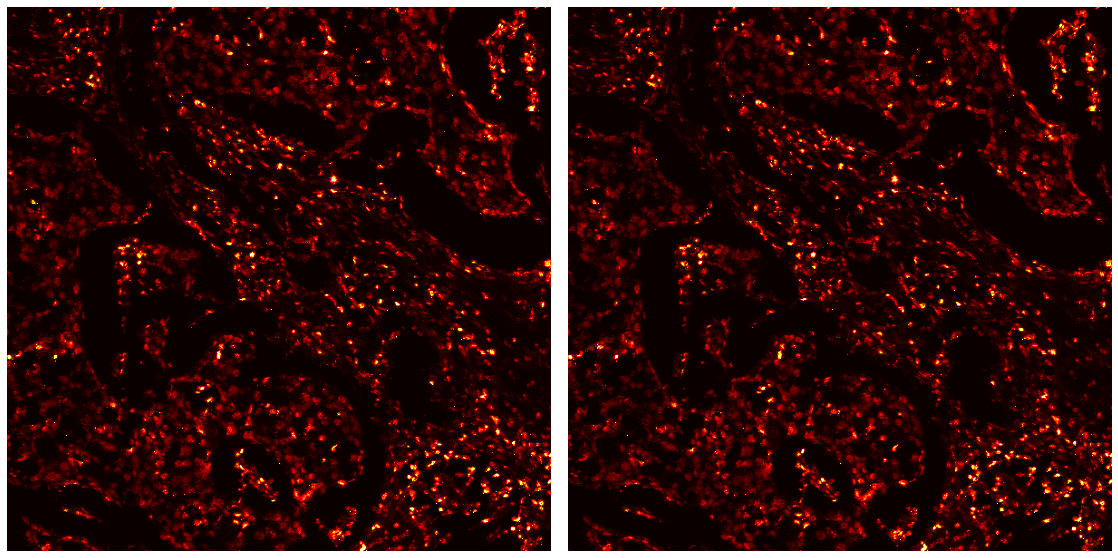

CD45RO
[False  True] [779010  48833]


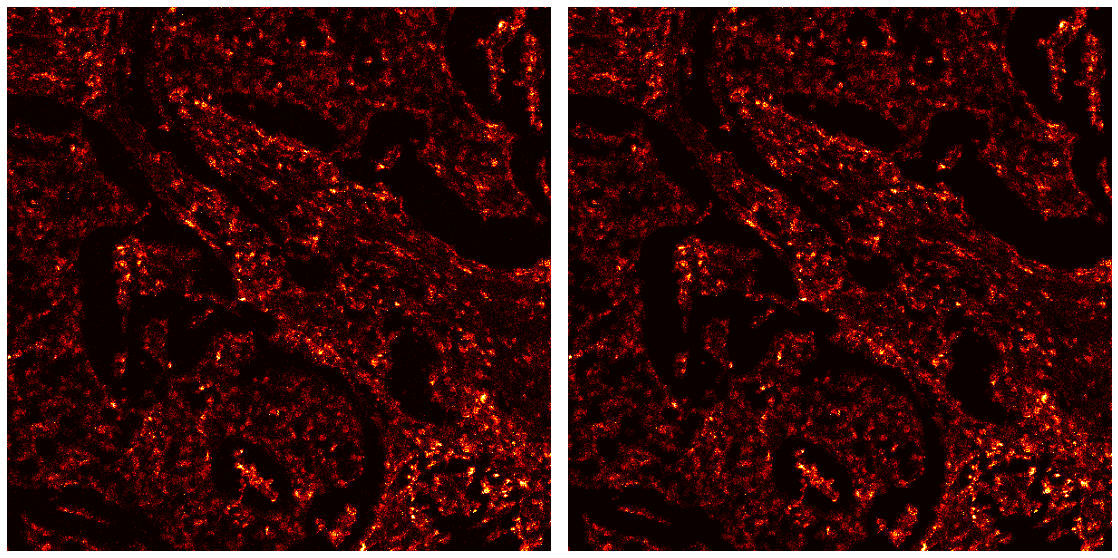

DNA1
[False  True] [1532615   49710]


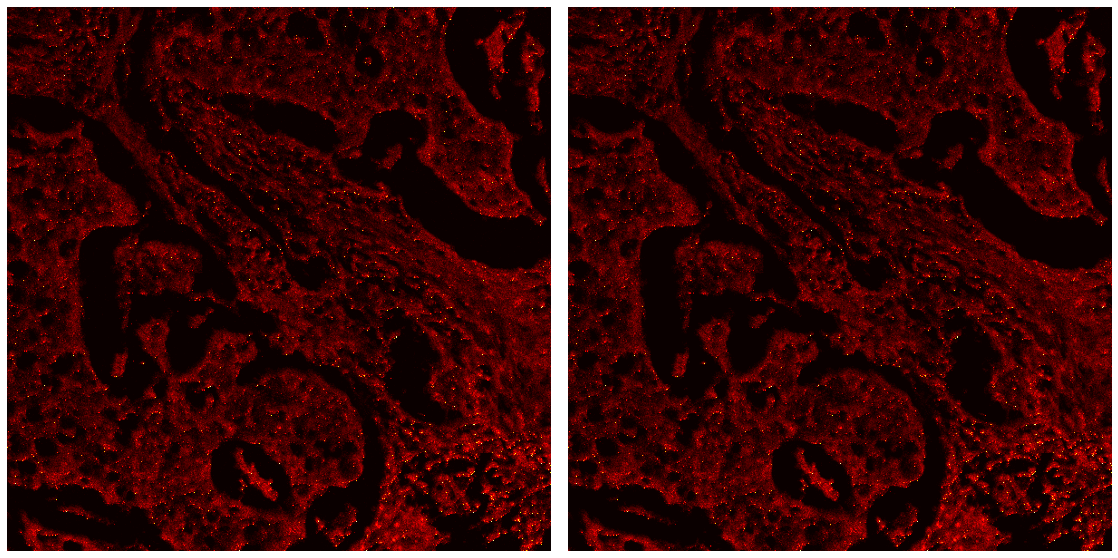

DNA2
[False  True] [1662975   32420]


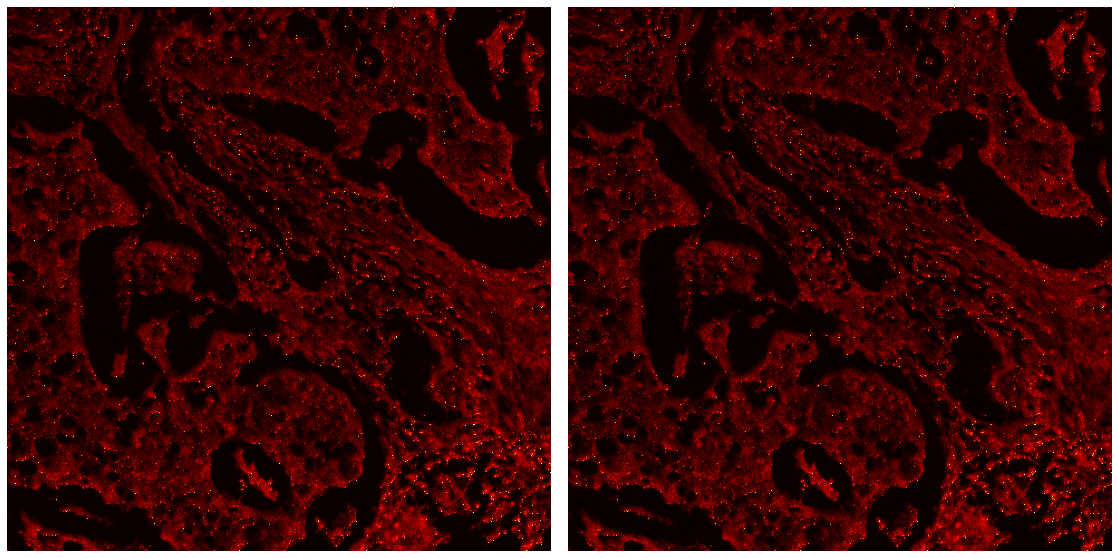

In [63]:
imgs_filtered = []

for i, img in enumerate(imgs):
    print(markers[i])
    if markers[i] in ["GranzymeB", "Ki67", "CD3", "CD20", "CD4"]:
        img_filtered = filter_img_knn(img, th=5)
    # elif markers[i] in ['PanKeratin', 'ECadherin']:
    #     img_filtered = img
    else:
        img_filtered = filter_img_knn(img, th=4)

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(img[700:1300, 700:1300], interpolation=None, cmap="hot")
    ax[0].axis("off")
    ax[1].imshow(img_filtered[700:1300, 700:1300], interpolation=None, cmap="hot")
    ax[1].axis("off")
    fig.subplots_adjust(wspace=0.01)
    plt.show()

    imgs_filtered.append(img_filtered)

# Save Data

In [64]:
core = core.split("_")[0] + ".hdf5"
path = h5_data_dir = p_dir / "data" / "h5" / core

imgs = np.stack(imgs_filtered, axis=0)
my_utils.save_hdf5(path, "IMC", imgs, {"markers": markers})